In [10]:
import os
import nibabel as nib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage import transform
from skimage.transform import resize
import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics.classification import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)

def compactness(blob_labels):
    import math
    compactness=[]
    region=regionprops(blob_labels)
    for rp in region:
        area=rp.area
        #perimeter=rp.perimeter
        perimeter=rp.perimeter_crofton
        c=(4*math.pi*area)/(perimeter**2)
        compactness.append(c)
    return compactness

def get_blobs(image,lesion_size):
    """
    gets the noise image after pre processing and returns blobs with the size equal to lesion size
    image is the noise image 
    lesion_size can be an int
    """
    
    labeled, nr_objects = ndimage.label(image)
    sizes = ndimage.sum_labels(image,labeled,range(nr_objects+1))    
    mask_size=sizes!=lesion_size
    small_blobs=labeled.copy()
    remove_pixel = mask_size[small_blobs]
    small_blobs[remove_pixel] = 0 
    
    return small_blobs


def list_lesions(image,lesion_size):
    round_lesion_c=0.8 #lesions with compactness above this value are considered round
    not_round_lesion_c=0.4 #lesions with compactness bellow this value are considered not round
    
    border=2
    blur=0.75
    
    less_size=lesion_size*0.05*blur #the lesion is smaller after the blur
    
    small_blobs=get_blobs(image,lesion_size)
    rb=regionprops(small_blobs)
    round_lesions=[]
    not_round_lesions=[]
    c_list=compactness(small_blobs)
    
    for blob in range(len(c_list)):
        
        if c_list[blob]>round_lesion_c:#round lesions

            blob_img=rb[blob].image.astype(float)
            #the image is padded because when it is smoothed it increases a bit
            pad_img=np.pad(array=blob_img, pad_width=border, mode='constant', constant_values=0)
            blur_image=ndimage.gaussian_filter(pad_img, blur)
            blur_image[blur_image<0.2]=0
            energy=round(np.sum(blur_image.astype(float)),2)
            if energy<=lesion_size-less_size+1 and energy>=lesion_size-less_size-1:
                round_lesions.append([blur_image,round(c_list[blob],3)])
        
        
        elif c_list[blob]<not_round_lesion_c:# not round lesions
            blob_img=rb[blob].image.astype(float)
            #the image is padded because when it is smoothed it increases a bit
            pad_img=np.pad(array=blob_img, pad_width=border, mode='constant', constant_values=0)
            blur_image=ndimage.gaussian_filter(pad_img, blur)
            blur_image[blur_image<0.15]=0
            energy=round(np.sum(blur_image.astype(float)),2)
            if energy<=lesion_size-less_size+1 and energy>=lesion_size-less_size-1:
                not_round_lesions.append([blur_image,round(c_list[blob],3)])
            
    return round_lesions, not_round_lesions

def create_lesions(lesion_number,lesion_size,factor=1):
    #factor is the value for which we multiply the sides of the lesion
    round_lesions=[]
    not_round_lesions=[]
    s=0
    size_noise=256
    blur_radius=2

    while len(not_round_lesions)<=lesion_number or len(round_lesions)<=lesion_number:
        #create noise
        np.random.seed(s)
        noise_img=np.random.rand(size_noise,size_noise)

        #smooth noise
        imgf=ndimage.gaussian_filter(noise_img, blur_radius)

        #create binary image
        thr=threshold_otsu(imgf)
        imgf_bin=imgf>thr
        
        #morphologic changes
        erosion_image=ndimage.binary_erosion(imgf_bin)
        open_er_img=ndimage.binary_opening(erosion_image)
        erosion_image2=ndimage.binary_erosion(open_er_img)

        #images
        

        #as a result from one noise image we create several images that can be used to create the lesions
        round_lesions_open, not_round_lesions_open=list_lesions(open_er_img,lesion_size)
        round_lesions_er, not_round_lesions_er=list_lesions(erosion_image2,lesion_size)
        
        round_lesions=round_lesions+round_lesions_open+round_lesions_er
        not_round_lesions=not_round_lesions+not_round_lesions_open+not_round_lesions_er
        
        
        #print('len lists:',len(round_lesions),len(not_round_lesions))
        '''        
        plt.figure(figsize=(15,7))
        plt.subplot(2,4,1)
        plt.imshow(noise_img)
        plt.title('noise')
        plt.subplot(2,4,2)
        plt.imshow(imgf)
        plt.title('blur')
        plt.subplot(2,4,3)
        plt.imshow(imgf_bin)
        plt.title('binary img')
        plt.subplot(2,4,4)
        plt.imshow(erosion_image)
        plt.title('erosion')
        plt.subplot(2,4,5)
        plt.imshow(open_er_img)
        plt.title('open')
        plt.subplot(2,4,6)
        plt.imshow(erosion_image2)
        plt.title('erosion2')
        plt.subplot(2,4,7)
        plt.imshow(dilated_image)
        plt.title('dilation')
        break
        '''
        
        s+=1
    print(f'round lesions: {len(round_lesions)}/{lesion_number} === not round lesions {len(not_round_lesions)}/{lesion_number}')
    print(f'number of seeds used: {s-1}')
    print(f'the lesions have size between {lesion_size-lesion_size*0.05*0.75-1} and {lesion_size-lesion_size*0.05*0.75+1}')
    
    lesions_r=round_lesions[:lesion_number]
    lesions_nr=not_round_lesions[:lesion_number]
    round_lesions=[[np.array(resize(round_lesions[i][0],(round_lesions[i][0].shape[0]*factor,round_lesions[i][0].shape[1]*factor))),round_lesions[i][1]] for i in range(len(lesions_r))]
    not_round_lesions=[[np.array(resize(not_round_lesions[i][0],(not_round_lesions[i][0].shape[0]*factor,not_round_lesions[i][0].shape[1]*factor))),not_round_lesions[i][1]] for i in range(len(lesions_nr))]
    
    return round_lesions, not_round_lesions

def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

def select_coordinates(slice_image, lesions,white_constant,seed):
    '''
    slice_image is the brain slice to use
    lesions is a list of the lesions (with len=number_of_lesions) to use
    colour_lesion is either 'black' or 'white'
    white_constant is the constant that is multiplied with the lesion mask to create lighter or darker lesions
    '''

    np.random.seed(seed)
    
    brain_mask=np.array(slice_image)>0
    brain_mask=brain_mask.astype(float)
    x,y = np.where(brain_mask == 1.)
    
    lesion_brain=slice_image.copy().astype(float)
    lesion_mask=brain_mask.copy() 
    lesion_added=0
    ground_truth=np.zeros(slice_image.shape)
    min_value=0.0 #min value for the lesion intensity 
    max_value=0.9 #max value for the lesion intensity
    brain_image=slice_image.copy()
    
    while lesion_added<len(lesions):
        i=np.random.choice(np.arange(len(x)))
        coordinate=[x[i],y[i]]
        lesion=lesions[lesion_added]
        lesion_rescale = rescale_values(lesion,max_value,min_value)
        lesion_rescale=rescale_values(lesion,white_constant,min_value)
        
        #creating the lesion mask and ground truth
        if (brain_mask[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]] ==1).all():
            #checks if the lesion that will be added is completly in a white space of the lesion mask 
            #(this means that the new lesion is not overlaping an existing one and is completly in the brain area)
            lesion_mask[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]] -= lesion_rescale
            lesion_added+=1
            ground_truth[coordinate[0]: coordinate[0] + lesion.shape[0], coordinate[1]: coordinate[1] + lesion.shape[1]]+=lesion
            brain_mask=lesion_mask

    
    brain_image=slice_image.copy()
    brain_mask=np.array(slice_image)>0
    #creating the white lesions
       
    brain_image[brain_image>0]=1-brain_image[brain_image>0]        
    brain_image[lesion_mask!=0]*=lesion_mask[lesion_mask!=0]
    brain_image[brain_mask]=1-brain_image[brain_mask]
    

    
    return lesion_mask,brain_image,ground_truth
    
def add_lesions(slice_image,round_lesions,not_round_lesions,min_lesion,max_lesion,white_constant,seed,max_brain):
    #for each slice we chose: random number of lesions, random lesions, random coordinates
    
    np.random.seed(seed)
    number_of_lesions=np.random.randint(min_lesion,max_lesion+1)
    lesion_type=np.random.randint(0,2)
    #lesion_type=0 - round
    #lesion_type=1 - not round
    
    #get lesions from type of lesions (and target)
    added=rescale_values(slice_image.copy(),max_brain,0)
    if lesion_type==0: #round
        target=0
        with open('round_lesions.pkl', 'rb') as f:
            lesion_list=pickle.load(f)
        np.random.shuffle(round_lesions)
        
    elif lesion_type==1: #not round
        target=1
        with open('not_round_lesions.pkl', 'rb') as f:
            lesion_list=pickle.load(f) 
        np.random.shuffle(lesion_list)
        
    lesions=[i[0] for i in lesion_list[:number_of_lesions]]
    #add the lesions
    
    lesion_mask,lesion_brain_white,ground_truth=select_coordinates(added, lesions,white_constant,seed)
    
    
    return lesion_mask,lesion_brain_white,ground_truth,target,number_of_lesions

def change_images(image):
    image=np.repeat(image[..., np.newaxis], 3, axis=2)
    image=resize(image, (224, 224))
    image=image.transpose(2,0,1)
    return image

def create_dataset(slices,round_lesions,not_round_lesions,min_lesion=3,max_lesion=5,white_constant=0.85,seed=0,max_brain=1):

    dataset_white=[]
    number_lesions=[]
    lesion_mask_list=[]
    ground_truths=[]
    for slice_idx in range(len(slices)):
        lesion_mask,lesion_brain_white,ground_truth,target,number_of_lesions=add_lesions(slices[slice_idx],
                                                                                         round_lesions,
                                                                                         not_round_lesions,
                                                                                         min_lesion=min_lesion,
                                                                                         max_lesion=max_lesion,
                                                                                         white_constant=white_constant,
                                                                                        seed=seed,
                                                                                        max_brain=max_brain)
        dataset_white.append([change_images(lesion_brain_white),target])
        number_lesions.append(number_of_lesions)
        lesion_mask_list.append(lesion_mask)
        ground_truths.append(ground_truth)
        seed+=1
        
        if slice_idx%1500==0:
            print(f'slice {slice_idx}/{len(slices)} = {round(100*slice_idx/len(slices),2)}%')
        
    return dataset_white,number_lesions,lesion_mask_list,ground_truths
        
    


# Creating the dataset

In [3]:
  
seed=0
np.random.seed(seed)
random.seed(seed)
plt.rc('image',cmap='gray')  

start = time.time()

number_of_lesions=50 #amount of lesions in each lesion list
size_of_lesions=70 #size of all the lesions
factor=2

round_lesions, not_round_lesions=create_lesions(number_of_lesions,size_of_lesions,factor=factor)

done = time.time()
elapsed = done - start
print(f'took {round(elapsed,2)}s')

t0=time.time()

with open('slices_training.pkl', 'rb') as f:
    training_slices,target_train_gender,target_train_age = pickle.load(f)
    
with open('slices_validation.pkl', 'rb') as f:
    validation_slices,target_valid_gender,target_valid_age = pickle.load(f)
    
with open('slices_holdout.pkl', 'rb') as f:
    holdout_slices,target_hold_gender,target_hold_age = pickle.load(f)
    
print(f'total time: {(time.time()-t0) // 60:.0f}m {(time.time()-t0) % 60:.0f}s')

round lesions: 51/50 === not round lesions 207/50
number of seeds used: 886
the lesions have size between 66.375 and 68.375
took 9.83s
total time: 4m 47s


In [4]:
k=2500

val_indexes=random.sample(range(0, len(validation_slices)), k) 
validation_slices=[validation_slices[i] for i in val_indexes] # validation dataset with 2500 images

test_finetune_indexes=random.sample(range(0, len(holdout_slices)), k)
test_fine_tuning_slices = [holdout_slices[i] for i in test_finetune_indexes] # training dataset with 2500 images (from holdout slices)

test_test_indexes = random.sample([i for i in range(len (holdout_slices)) if i not in test_finetune_indexes],k)
test_hold_slices = [holdout_slices[i] for i in test_test_indexes] # hold out dataset with 2500 images (from different holdout slices)


In [5]:
lesion_max_intensity=0.5

### Training dataset
start = time.time()
t0=time.time()
initial_seed=0
max_brain_intensity=0.7

print(' ====== training ====== ')
training_dataset,number_lesions_train,lesion_mask_list_train,ground_truths_train=create_dataset(test_fine_tuning_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed,
                                                                              max_brain=max_brain_intensity)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target=[i[1] for i in training_dataset]
print(f'{len([i for i in target if i==1])} slices of target 1 out of {len(target)} slices: {round(100*len([i for i in target if i==1])/len(target),2)} %')
print(f' number of slices: {len(training_dataset)}')
print()



### Validation dataset
print(' ====== validation ====== ')
start = time.time()

validation_dataset,number_lesions_valid,lesion_mask_list_valid,ground_truths_valid=create_dataset(validation_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed+30000,
                                                                              max_brain=max_brain_intensity)


done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in validation_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(validation_dataset)}')
print()

### Holdout dataset
start = time.time()
print(' ====== holdout ====== ')

holdout_dataset,number_lesions_hold,lesion_mask_list_hold,ground_truths_hold=create_dataset(test_hold_slices,
                                                                              round_lesions,
                                                                              not_round_lesions,
                                                                              min_lesion=3,
                                                                              max_lesion=5,
                                                                              white_constant=lesion_max_intensity,
                                                                              seed=initial_seed+50000,
                                                                              max_brain=max_brain_intensity)

done = time.time()
elapsed = done - start
print()
print(f'took {round(elapsed,2)}s')
target_w=[i[1] for i in holdout_dataset]
print(f'{len([i for i in target_w if i==1])} slices of target 1 out of {len(target_w)} slices: {round(100*len([i for i in target_w if i==1])/len(target_w),2)} %')
print(f' number of slices: {len(holdout_dataset)}')

print(f'total time: {(time.time()-t0) // 60:.0f}m {(time.time()-t0) % 60:.0f}s')

 ====== training ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 47.02s
1210 slices of target 1 out of 2500 slices: 48.4 %
 number of slices: 2500

 ====== validation ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 47.83s
1217 slices of target 1 out of 2500 slices: 48.68 %
 number of slices: 2500

 ====== holdout ====== 
slice 0/2500 = 0.0%
slice 1500/2500 = 60.0%

took 46.63s
1265 slices of target 1 out of 2500 slices: 50.6 %
 number of slices: 2500
total time: 2m 21s


/tmp/ipykernel_606476/1892608239.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(resize(ground_truths_hold[n],(224,224)),levels=[1],colors=['blue'])
/tmp/ipykernel_606476/1892608239.py:15: UserWarning: No contour levels were found within the data range.
  plt.contour(resize(ground_truths_hold[n],(224,224)),levels=[1],colors=['red'])


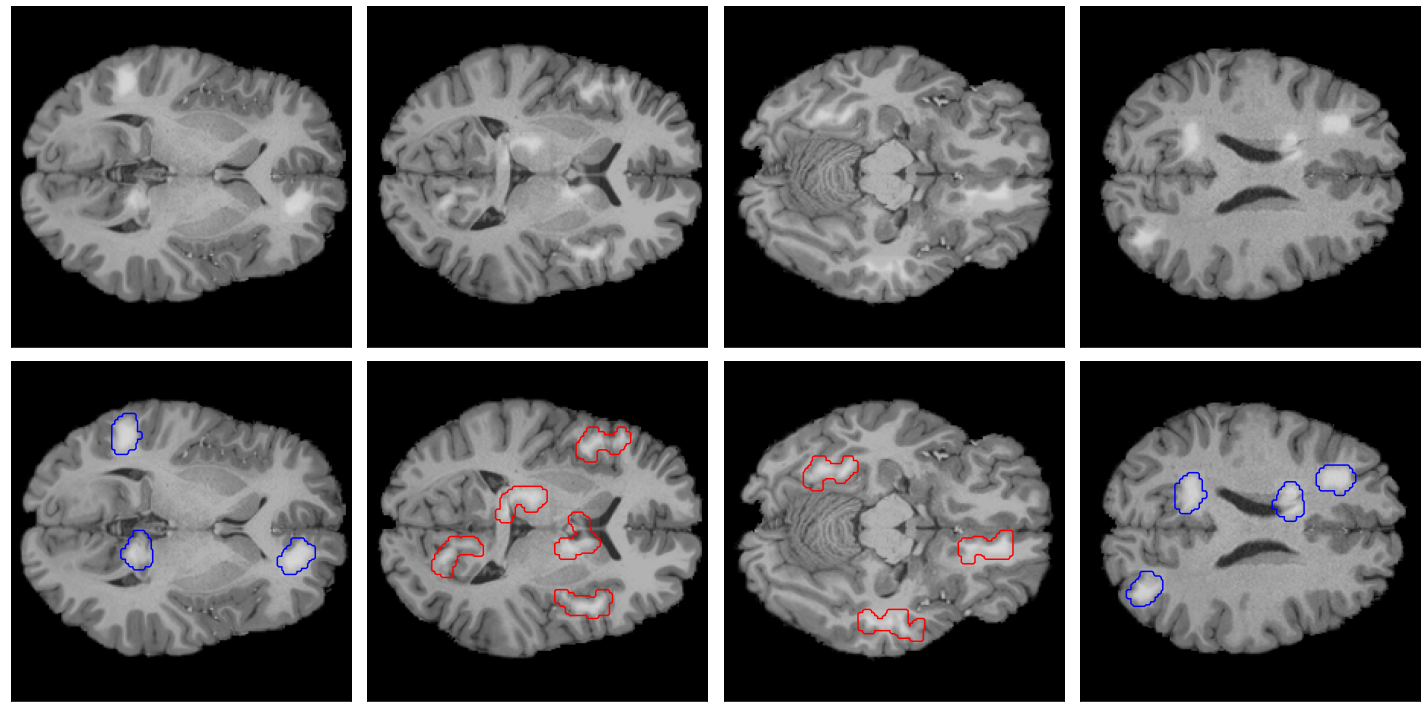

In [11]:
n=1
plt.figure(figsize=(20,10))
j=1
for i in range(4):
    plt.subplot(2, 4, j)
    plt.imshow(holdout_dataset[n][0].transpose(1,2,0),vmax=1,vmin=0)
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(2, 4, j + 4)
    plt.imshow(holdout_dataset[n][0].transpose(1,2,0),vmax=1,vmin=0)
    if holdout_dataset[n][1] == 0:
        plt.contour(resize(ground_truths_hold[n],(224,224)),levels=[1],colors=['blue'])
    else: 
        plt.contour(resize(ground_truths_hold[n],(224,224)),levels=[1],colors=['red'])
    plt.yticks([])
    plt.xticks([])

    n+=500
    j += 1
    plt.tight_layout()

# Fine-tuning the model

In [24]:

def load_VGG_model(path,device):
    model = models.vgg16(pretrained=True)
    model.classifier=model.classifier[:-1]
    last_layers=[nn.Linear(4096,2)]
    model.classifier = nn.Sequential(*list(model.classifier)+last_layers) 

    model.load_state_dict(torch.load(path,map_location=device))

    model.to(device)
    return model

def train_model(name,DEVICE,train_loader,val_loader, model, criterion, optimizer, scheduler, num_epochs, stop_value, acc_dif_save):
    model.to(DEVICE)

    training_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    validation_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)

    since = time.time()
    best_acc=0
    
    val_acc=[0.0,0.0,0.0]
    train_acc=[0.0,0.0,0.0]
    train_losses=[0.0,0.0,0.0]
    val_losses=[0.0,0.0,0.0]    
    
    out=0

    for epoch in range(num_epochs):
        t0=time.time()
        if out:
            break
        
        epoch_accuracies = list()
        epoch_validation_accuracies = list()
        epoch_loss = 0
        epoch_validation_loss = 0
        num_batches_train = 0
                
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        real_labels=[]
        pred_labels=[]
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            inputs = inputs.to(DEVICE,dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels=labels.to(DEVICE)
            
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches_train += 1

            acc = training_accuracy(output, labels).item()
            epoch_accuracies.append(acc)
            
        train_acc.append(sum(epoch_accuracies)/len(epoch_accuracies))
        scheduler.step()
        
        num_batches_validation = 0
        
        real_labels=[]
        pred_labels=[]
        
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE,dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels=labels.to(DEVICE)
            
            output = model(inputs)
            _, preds = torch.max(output, 1)
            loss = criterion(output, labels)
            
            epoch_validation_loss += loss.item()
            num_batches_validation += 1
#             acc = validation_accuracy(output, labels).item()
#             epoch_validation_accuracies.append(acc)
            
            preds=np.array(torch.Tensor.cpu(preds))
            labels=np.array(torch.Tensor.cpu(labels))

            real_labels=real_labels+list(labels)
            pred_labels=pred_labels+list(preds)
        
        
        compare_lists=np.array(real_labels)==np.array(pred_labels)
        correct_indexes=np.where(compare_lists==True)
        
        acc=round(len(correct_indexes[0])/len(compare_lists),4)
        val_acc.append(acc)
        
       # val_acc.append(sum(epoch_validation_accuracies)/len(epoch_validation_accuracies))

        epoch_loss /= num_batches_train
        epoch_validation_loss /= num_batches_validation

        train_losses.append(epoch_loss)
        val_losses.append(epoch_validation_loss)
        
        if epoch==0:
            PATH = name + '.pt'
            torch.save(model.state_dict(), PATH)
            
        if val_acc[-1]>best_acc and abs(val_acc[-1]-train_acc[-1]) <= acc_dif:
            PATH = name + '.pt'
            best_acc = val_acc[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_wts)
            torch.save(model.state_dict(), PATH)
            print('\t \t \t \t *** best model ***')  
        
#         if (val_acc[-1]-train_acc[-1]<-stop_value and val_acc[-2]-train_acc[-2]<-stop_value and val_acc[-3]-train_acc[-3]<-stop_value):# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
#             print('out')
#             out=True
            
        if abs(val_acc[-1]-val_acc[-2])<stop_value and abs(val_acc[-2]-val_acc[-3])<stop_value and abs(val_acc[-3]-val_acc[-4])<stop_value and val_acc[-1]<train_acc[-1] and val_acc[-2]<train_acc[-2] and val_acc[-3]<train_acc[-3]:# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
            print('out')
            out=True
            
                
#         if abs(val_acc[-1]-val_acc[-2])<=stop_value and abs(val_acc[-2]-val_acc[-3])<=stop_value and abs(val_acc[-3]-val_acc[-4])<=stop_value:# or (val_losses[-1]<val_losses[-2] and val_losses[-2]<val_losses[-3] and val_losses[-3]<val_losses[-4]): 
#             print('out')
#             out=True
            
        print(f'Training Loss: {train_losses[-1]:.4f} Acc: {train_acc[-1]:.4f}')
            
        print(f'Validation Loss: {val_losses[-1]:.4f} Acc: {val_acc[-1]:.4f}')
        
        time_elapsed = time.time() - t0
        print(f'took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
        
    model=None
    best_model_wts=None
    best_acc=None
    hold_loader=None
    val_loader=None
    train_loader=None
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
      
    return val_acc[2:],train_acc[2:],val_losses[2:],train_losses[2:]


def acc1(data_loader,model,DEVICE):
    accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    acc_tot=[]
    real_labels=[]
    pred_labels=[]
    
    for inputs, labels in data_loader:

        inputs = inputs.to(DEVICE,dtype=torch.float)
        labels = labels.type(torch.LongTensor)
        labels=labels.to(DEVICE)

        model.to(DEVICE)
        output = model(inputs)

        acc = accuracy(output, labels).item()
        acc_tot.append(acc)

        real_labels+=torch.Tensor.cpu(labels).tolist()
        pred_labels+=torch.Tensor.cpu(torch.max(output, 1)[1]).tolist()
        
    acc=sum(acc_tot)/len(acc_tot)
    
        
        
    inputs=None
    labels=None
    model=None
    
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return acc,real_labels,pred_labels



In [26]:
import math
import random

def training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                 LR,batch_size,SEED,acc_dif,stop_value,white_constant,EPOCHS=40, weight_decay = 0):

    
    DEVICE= torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    manual_seed(SEED)
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.default_rng(SEED)
    np.random.seed(SEED)
    
    print('creating dataloaders...')
    train_loader = DataLoader(training_dataset,batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset,batch_size=batch_size, shuffle=False)
    hold_loader = DataLoader(holdout_dataset,batch_size=batch_size, shuffle=False)
    
    
    #model
    if MRI:
        print('loading MRI model...')
        file_PATH='MRI_pretrained_model.pt'
        vgg16_pretrained = load_VGG_model(file_PATH,DEVICE)
        vgg16_pretrained.to(DEVICE)
        
        name='zz_new_finetuning_'+block+'_'+str(white_constant)+'_MRI_new_'+str(len(training_dataset))+'_'+str(LR)+'_'+str(SEED)

    else:
        print('loading imagenet model...')
        vgg16_pretrained = models.vgg16(pretrained=True)
        vgg16_pretrained.classifier=vgg16_pretrained.classifier[:-1]
        last_layers=[nn.Linear(4096,2)]
        vgg16_pretrained.classifier = nn.Sequential(*list(vgg16_pretrained.classifier)+last_layers) 
        vgg16_pretrained.to(DEVICE)
        
        name='zz_new_finetuning_'+block+'_'+str(white_constant)+'_img_new_'+str(len(training_dataset))+'_'+str(LR)+'_'+str(SEED)
        

    print('##############',name,'##############')
    
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer_conv = optim.SGD(vgg16_pretrained.parameters(), lr=LR, momentum=0.5,weight_decay=weight_decay)
    #here to change the 
    # Decay LR by a factor of 0.1 every 5 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    training_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    validation_accuracy = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
    
    for param in vgg16_pretrained.parameters():
        param.requires_grad = False
    
    if block=='1conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[25:]]
    elif block=='2conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[18:]]
    elif block=='3conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[11:]]
    elif block=='4conv':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[6:]]
    elif block=='all':
        unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[:]]
        
    for layer in unfreeze_layers:
        for param in layer.parameters():
            param.requires_grad = True

    print('training...')
    val_acc,train_acc,val_losses,train_losses=train_model(name,DEVICE,train_loader,val_loader, vgg16_pretrained, criterion, optimizer_conv,
                         exp_lr_scheduler, EPOCHS, stop_value, acc_dif)
    

    to_save=[val_acc[1:],train_acc[1:],val_losses[1:],train_losses[1:]]

    with open('new_losses_' + name + '.pkl', 'wb') as f:
         pickle.dump(to_save,f)    

    ax1 = plt.subplot()
    l1, = ax1.plot(val_acc[1:],'c')
    l2, = ax1.plot(train_acc[1:], color='r')

    ax2 = ax1.twinx()
    l3, = ax2.plot(train_losses[1:], '--r')
    l4, = ax2.plot(val_losses[1:], 'c--')

    plt.legend([l1, l2,l3,l4], ["val acc", "train acc","train loss","val loss"])

    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy', color='black')
    ax2.set_ylabel('losses', color='black')

    plt.show()


    DEVICE = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    PATH = name + '.pt'
    model = load_VGG_model(PATH,DEVICE)
    model.to(DEVICE)

    print('getting accuracies...')
    train_acc,_,_=acc1(train_loader,model,DEVICE)
    val_acc,_,_=acc1(val_loader,model,DEVICE)
    hold_acc,real_labels,pred_labels=acc1(hold_loader,model,DEVICE)    

    print(f'Train accuracy: {train_acc}')
    print(f'Validation accuracy: {val_acc}')
    print(f'Holdout accuracy: {hold_acc}')

    parameters_to_save={'SEED':SEED,
                        'acc_dif':acc_dif,
                        'LR':LR,
                        'block':block,
                        'model_name':name,
                       'train_acc':train_acc,
                       'val_acc':val_acc,
                       'hold_acc':hold_acc
                       }

    '''
    print('getting ratios...')
    

   
    
    vgg16_pretrained.features[1]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[3]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[6]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[8]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[11]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[13]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[15]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[18]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[20]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[22]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[25]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[27]=nn.ReLU(inplace=False)
    vgg16_pretrained.features[29]=nn.ReLU(inplace=False)
    vgg16_pretrained.classifier[1]=nn.ReLU(inplace=False)
    vgg16_pretrained.classifier[4]=nn.ReLU(inplace=False)
        
    print()
    print('obtaining ratios of pixels in ground truth...')
    ratios,EMDs=get_ratios_list(vgg16_pretrained,holdout_dataset,DEVICE,ratio=1,emd=0)

    print(hold_acc)
    to_save=[hold_acc,ratios,EMDs,real_labels,pred_labels]

    path='/home/martao/MRI_dataset/2ndTry/Models/Ratios/'

    with open(f'{path}{name}_ratios_.pkl', 'wb') as f:
        pickle.dump(to_save,f)
    
    '''
    
    vgg16_pretrained=None
    train_loader=None
    val_loader=None
    hold_loader=None
    train_acc=None
    val_acc=None
    real_labels=None
    pred_labels=None
    model=None
    import gc

    
    print()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return hold_acc
    


In [13]:

block='4conv'
DEVICE='cuda:0'
vgg16_pretrained = models.vgg16(pretrained=True)
vgg16_pretrained.classifier=vgg16_pretrained.classifier[:-1]
last_layers=[nn.Linear(4096,2)]
vgg16_pretrained.classifier = nn.Sequential(*list(vgg16_pretrained.classifier)+last_layers) 
vgg16_pretrained.to(DEVICE)


for param in vgg16_pretrained.parameters():
    param.requires_grad = False

if block=='1conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[25:]]
elif block=='2conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[18:]]
elif block=='3conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[11:]]
elif block=='4conv':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[6:]]
elif block=='all':
    unfreeze_layers=[vgg16_pretrained.classifier[:],vgg16_pretrained.features[:]]

for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

summary(vgg16_pretrained,(3,240,240))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           1,792
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 64, 240, 240]          36,928
              ReLU-4         [-1, 64, 240, 240]               0
         MaxPool2d-5         [-1, 64, 120, 120]               0
            Conv2d-6        [-1, 128, 120, 120]          73,856
              ReLU-7        [-1, 128, 120, 120]               0
            Conv2d-8        [-1, 128, 120, 120]         147,584
              ReLU-9        [-1, 128, 120, 120]               0
        MaxPool2d-10          [-1, 128, 60, 60]               0
           Conv2d-11          [-1, 256, 60, 60]         295,168
             ReLU-12          [-1, 256, 60, 60]               0
           Conv2d-13          [-1, 256, 60, 60]         590,080
             ReLU-14          [-1, 256,

creating dataloaders...
loading imagenet model...
############## new_finetuning_all_0.5_img_new_2500_0.005_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7140 Acc: 0.5312
Validation Loss: 0.6803 Acc: 0.5704
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6405 Acc: 0.6286
Validation Loss: 1.1404 Acc: 0.5132
took 0m 31s

Epoch 2/39
----------
Training Loss: 0.6938 Acc: 0.5380
Validation Loss: 0.6565 Acc: 0.6480
took 0m 32s

Epoch 3/39
----------
Training Loss: 0.5606 Acc: 0.7188
Validation Loss: 0.4656 Acc: 0.7728
took 0m 32s

Epoch 4/39
----------
Training Loss: 0.3319 Acc: 0.8616
Validation Loss: 0.0692 Acc: 0.9764
took 0m 31s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.0736 Acc: 0.9703
Validation Loss: 0.0416 Acc: 0.9848
took 0m 40s

Epoch 6/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.0295 Acc: 0.9905
Validation Loss: 0.0190 Acc: 0.9936
took 0m 39s

Epoch 7/39
----------
	 	 	 	 *** best mo

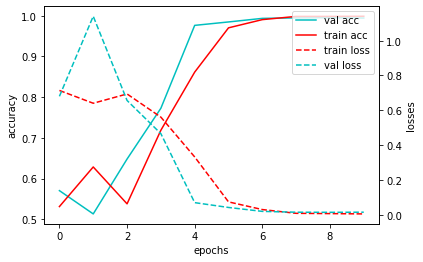

getting accuracies...



Train accuracy: 0.9992088607594937
Validation accuracy: 0.9948575949367089
Holdout accuracy: 0.9940664556962026



In [20]:
SEED = 55168461
LR = 0.005
MRI = 0
block='4conv'
batch_size=32
acc_dif=0.05
stop_value=0.005
EPOCHS = 40

training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.005_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7148 Acc: 0.5083
Validation Loss: 0.6891 Acc: 0.5336
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6826 Acc: 0.5558
Validation Loss: 0.7150 Acc: 0.5204
took 0m 30s

Epoch 2/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6764 Acc: 0.5570
Validation Loss: 0.6880 Acc: 0.5504
took 0m 38s

Epoch 3/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6695 Acc: 0.5827
Validation Loss: 0.6795 Acc: 0.5664
took 0m 38s

Epoch 4/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6448 Acc: 0.6286
Validation Loss: 0.6681 Acc: 0.5924
took 0m 38s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6191 Acc: 0.6559
Validation Loss: 0.6419 Acc: 0.6128
took 0m 37s

Epoch 6/39
----------
Training Loss: 0.6135 Acc: 0.6752
Validation Loss: 0.6547 Acc: 0.6112
took 

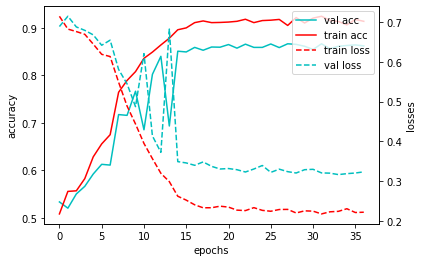

getting accuracies...



Train accuracy: 0.9161392405063291
Validation accuracy: 0.8571993670886076
Holdout accuracy: 0.8615506329113924

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.01_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7139 Acc: 0.5059
Validation Loss: 0.6899 Acc: 0.5388
took 0m 49s

Epoch 1/39
----------
Training Loss: 0.6873 Acc: 0.5459
Validation Loss: 0.7328 Acc: 0.5128
took 0m 32s

Epoch 2/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6836 Acc: 0.5570
Validation Loss: 0.6884 Acc: 0.5408
took 0m 38s

Epoch 3/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6764 Acc: 0.5728
Validation Loss: 0.6851 Acc: 0.5556
took 0m 38s

Epoch 4/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6541 Acc: 0.6187
Validation Loss: 0.6671 Acc: 0.5916
took 0m 39s

Epoch 5/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6243 Acc: 0.6578
Validatio

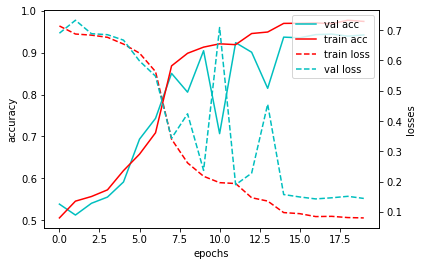

getting accuracies...



Train accuracy: 0.9691455696202531
Validation accuracy: 0.9382911392405063
Holdout accuracy: 0.9382911392405063

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.02_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7118 Acc: 0.4854
Validation Loss: 0.6926 Acc: 0.5192
took 0m 47s

Epoch 1/39
----------
Training Loss: 0.6939 Acc: 0.5047
Validation Loss: 0.7064 Acc: 0.5132
took 0m 28s

Epoch 2/39
----------
Training Loss: 0.6935 Acc: 0.5071
Validation Loss: 0.6942 Acc: 0.4996
took 0m 28s

Epoch 3/39
----------
Training Loss: 0.6953 Acc: 0.4925
Validation Loss: 0.6924 Acc: 0.5108
took 0m 29s

Epoch 4/39
----------
Training Loss: 0.6932 Acc: 0.5040
Validation Loss: 0.6933 Acc: 0.4972
took 0m 31s

Epoch 5/39
----------
Training Loss: 0.6938 Acc: 0.5020
Validation Loss: 0.6948 Acc: 0.5132
took 0m 28s

Epoch 6/39
----------
Training Loss: 0.6923 Acc: 0.5249
Validation L

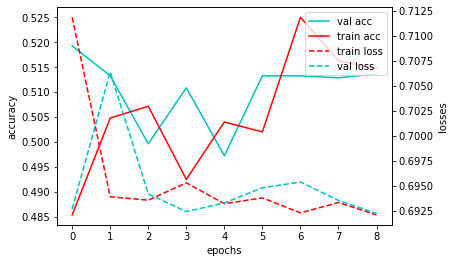

getting accuracies...



Train accuracy: 0.5399525316455697
Validation accuracy: 0.5189873417721519
Holdout accuracy: 0.49485759493670883

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7104 Acc: 0.4984
Validation Loss: 0.6928 Acc: 0.5172
took 0m 48s

Epoch 1/39
----------
Training Loss: 0.6939 Acc: 0.5059
Validation Loss: 0.7052 Acc: 0.5132
took 0m 29s

Epoch 2/39
----------
Training Loss: 0.6936 Acc: 0.5202
Validation Loss: 0.6939 Acc: 0.4936
took 0m 30s

Epoch 3/39
----------
Training Loss: 0.6949 Acc: 0.4945
Validation Loss: 0.6928 Acc: 0.5112
took 0m 30s

Epoch 4/39
----------
Training Loss: 0.6935 Acc: 0.5032
Validation Loss: 0.6932 Acc: 0.5000
took 0m 31s

Epoch 5/39
----------
Training Loss: 0.6941 Acc: 0.4980
Validation Loss: 0.6946 Acc: 0.5132
took 0m 32s

Epoch 6/39
----------
Training Loss: 0.6929 Acc: 0.5182
Validation 

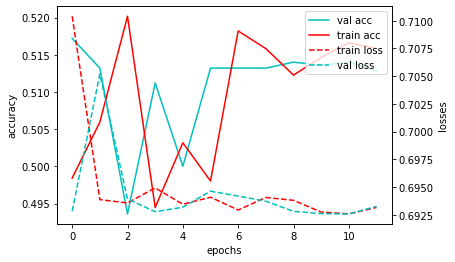

getting accuracies...



Train accuracy: 0.5098892405063291
Validation accuracy: 0.5170094936708861
Holdout accuracy: 0.495253164556962

creating dataloaders...
loading MRI model...
############## new_finetuning_all_0.5_MRI_new_2500_0.05_55168461 ##############
training...
Epoch 0/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.7169 Acc: 0.4893
Validation Loss: 0.6928 Acc: 0.5128
took 0m 46s

Epoch 1/39
----------
	 	 	 	 *** best model ***
Training Loss: 0.6928 Acc: 0.4992
Validation Loss: 0.6989 Acc: 0.5132
took 0m 36s

Epoch 2/39
----------
Training Loss: 0.6935 Acc: 0.5067
Validation Loss: 0.6934 Acc: 0.4904
took 0m 28s

Epoch 3/39
----------
Training Loss: 0.6943 Acc: 0.4941
Validation Loss: 0.6928 Acc: 0.5132
took 0m 28s

Epoch 4/39
----------
Training Loss: 0.6932 Acc: 0.4988
Validation Loss: 0.6931 Acc: 0.4964
took 0m 28s

Epoch 5/39
----------
Training Loss: 0.6939 Acc: 0.5016
Validation Loss: 0.6945 Acc: 0.5132
took 0m 30s

Epoch 6/39
----------
Training Loss: 0.693

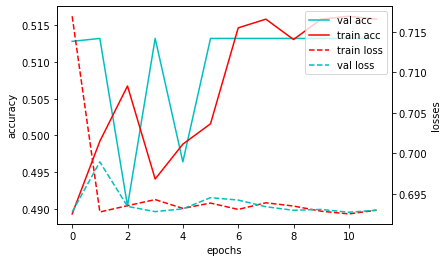

getting accuracies...



Train accuracy: 0.5130537974683544
Validation accuracy: 0.5130537974683544
Holdout accuracy: 0.4912974683544304



In [13]:
SEED = 55168461
LR = 0.005
MRI = 1
block='all'
batch_size=32
acc_dif=0.05
stop_value=0.005
EPOCHS = 40

LRs=[0.005,0.01,0.02,0.03,0.05]

for LR in LRs:
    training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)

In [15]:
import pickle
with open('val_indexes.pkl', 'wb') as fp:
	pickle.dump(val_indexes, fp)
    
with open('test_test_indexes.pkl', 'wb') as fp:
	pickle.dump(test_test_indexes, fp)
        
with open('test_finetune_indexes.pkl', 'wb') as fp:
	pickle.dump(test_finetune_indexes, fp)

creating dataloaders...
loading MRI model...
############## zz_new_finetuning_4conv_0.5_MRI_new_2500_0.03_55168461 ##############
training...
Epoch 0/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.7119 Acc: 0.5000
Validation Loss: 0.6917 Acc: 0.5168
took 0m 44s

Epoch 1/49
----------
Training Loss: 0.6925 Acc: 0.5174
Validation Loss: 0.7493 Acc: 0.5132
took 0m 25s

Epoch 2/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.6920 Acc: 0.5229
Validation Loss: 0.6918 Acc: 0.5252
took 0m 34s

Epoch 3/49
----------
Training Loss: 0.6889 Acc: 0.5328
Validation Loss: 0.6845 Acc: 0.5228
took 0m 25s

Epoch 4/49
----------
Training Loss: 0.6746 Acc: 0.5882
Validation Loss: 0.6925 Acc: 0.5140
took 0m 23s

Epoch 5/49
----------
Training Loss: 0.6961 Acc: 0.5059
Validation Loss: 0.6915 Acc: 0.5152
took 0m 25s

Epoch 6/49
----------
Training Loss: 0.6892 Acc: 0.5301
Validation Loss: 0.6959 Acc: 0.5132
took 0m 25s

Epoch 7/49
----------
	 	 	 	 *** best model ***
Training Loss: 0.668

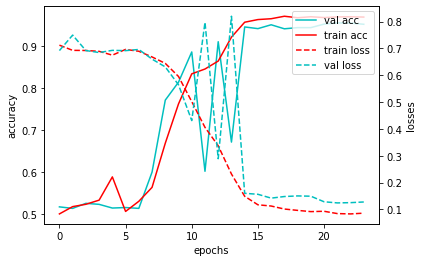

getting accuracies...



Train accuracy: 0.9715189873417721
Validation accuracy: 0.9513449367088608
Holdout accuracy: 0.9584651898734177



In [30]:
batch_size=32
acc_dif=0.06
stop_value=0.004
EPOCHS = 50
MRI = 1
LR = 0.03
block = '4conv'

seeds =[55168461]


for SEED in seeds:
    training_all_models(block,MRI,training_dataset,validation_dataset,holdout_dataset,
                    LR,batch_size,SEED,acc_dif,stop_value,lesion_max_intensity,EPOCHS)